In [ ]:
#import google drive
from google.colab import drive
drive.mount('/content/drive')
#import data processing, image processing, pandas, metrics, optimisers
import numpy as np
import pandas as pd
import random
import os
import glob
import cv2
from skimage.io import imread
from PIL import Image
from tqdm import tqdm
from skimage import io
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, jaccard_score, accuracy_score
from sklearn.model_selection import train_test_split
# Importing models Tenserflows and keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Add, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import layers

# visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/archive/lgg-mri-segmentation/kaggle_3m'

# Lists to store img paths and mask paths from dataset
imgPaths = []
mskPaths = []

# Looping thru the folders in dataset
folders = glob.glob(os.path.join(path, '*'))
for folder in folders:
    if os.path.isdir(folder):
        allFiles = os.listdir(folder)

        # Seperating the images and masks files within the folders seperatley
        imgs = sorted([f for f in allFiles if '_mask' not in f and f.endswith('.tif')])
        msks = sorted([f for f in allFiles if '_mask' in f and f.endswith('.tif')])

        # Map the imgs and msks lists together as the dataset has a brain mri scan and a mask of the same image.
        for img, msk in zip(imgs, msks):
            imgPaths.append(os.path.join(folder, img))
            mskPaths.append(os.path.join(folder, msk))

# Create a df of the paths
df = pd.DataFrame({
    'imgPath': imgPaths,
    'mskPath': mskPaths
})

df.head()

,imgPath,mskPath
0,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...
1,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...
2,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...
3,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...
4,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...


In [ ]:
# Function to detect if there is a tumour based on the mask
def tumor_detect(mskPath):
    mask = cv2.imread(mskPath, cv2.IMREAD_GRAYSCALE)  # convert grayscale
    # return 1 if theres a tumor as the np.max is more than 0, otherwise return 0.
    return 1 if np.max(mask) > 0 else 0

# adding a new column to the df that applies the function to every row in mskpath column to say either 1 for tumour and 0 for no tumour
df['hasTumor'] = df['mskPath'].apply(tumor_detect)
df.head()

,imgPath,mskPath,hasTumor
0,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...,1
1,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...,1
2,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...,1
3,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...,1
4,/content/drive/MyDrive/archive/lgg-mri-segment...,/content/drive/MyDrive/archive/lgg-mri-segment...,1


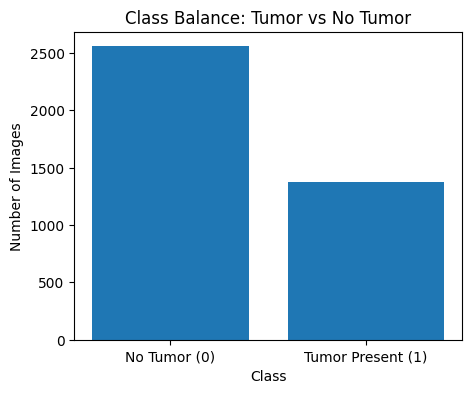

In [ ]:
# Count how many images have a tumor and how many dont to check for class imbalancement
clscnts = df['hasTumor'].value_counts()

# barchart to visualise the classes
plt.figure(figsize=(5,4))
plt.bar(clscnts.index.astype(str), clscnts.values)
plt.xticks([0, 1], ['No Tumor (0)', 'Tumor Present (1)'])
plt.title('Class Balance: Tumor vs No Tumor')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


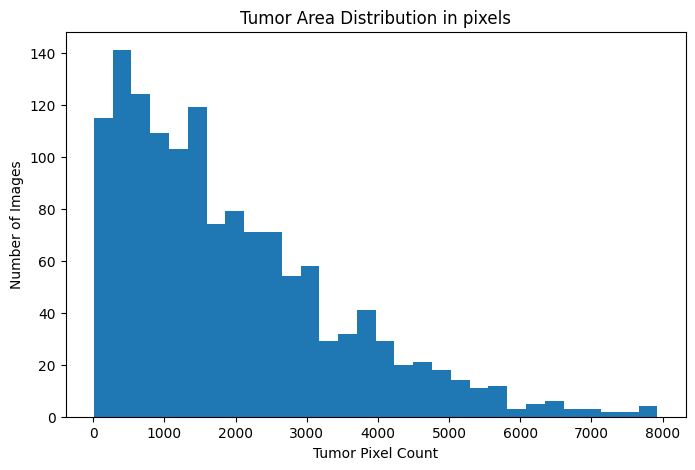

In [ ]:
# function to count how many pixels in the tumour
def tumorPixelCount(mskPath):
    mask = cv2.imread(mskPath, cv2.IMREAD_GRAYSCALE)
    return np.sum(mask == 255)

# applying the function to only where there is a tumor
dfTumor = df[df['hasTumor'] == 1].copy()
dfTumor.loc[:, 'tumorSize'] = dfTumor['mskPath'].apply(tumorPixelCount)

# Histogram of the tumor sizes
plt.figure(figsize=(8,5))
plt.hist(dfTumor['tumorSize'], bins=30)
plt.title('Tumor Area Distribution in pixels')
plt.xlabel('Tumor Pixel Count')
plt.ylabel('Number of Images')
plt.show()

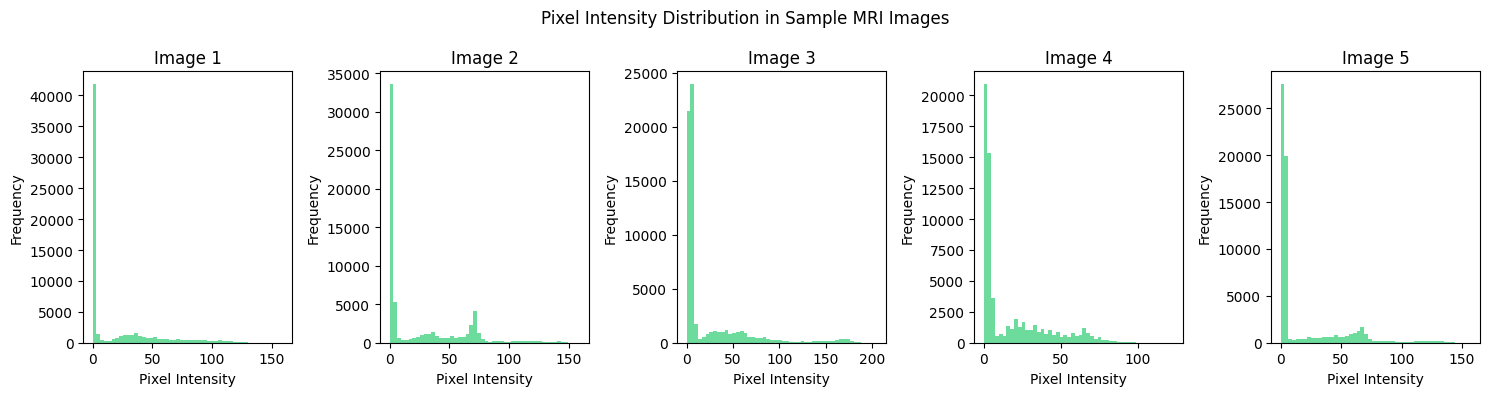

In [ ]:
# Randomly picking 5 images from the dataset and putting into list
smp_imgs = df.sample(5)['imgPath'].tolist()

plt.figure(figsize=(15, 4))
for i, imgPath in enumerate(smp_imgs):
    img = cv2.imread(imgPath)
    # convert to grayscale for intensity analysis
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Ploting the histogram of pixel intensities
    plt.subplot(1, 5, i+1)
    plt.hist(img.ravel(), bins=50, color='#2ecc71', alpha=0.7)
    plt.title(f'Image {i+1}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

plt.suptitle('Pixel Intensity Distribution in Sample MRI Images')
plt.tight_layout()
plt.show()


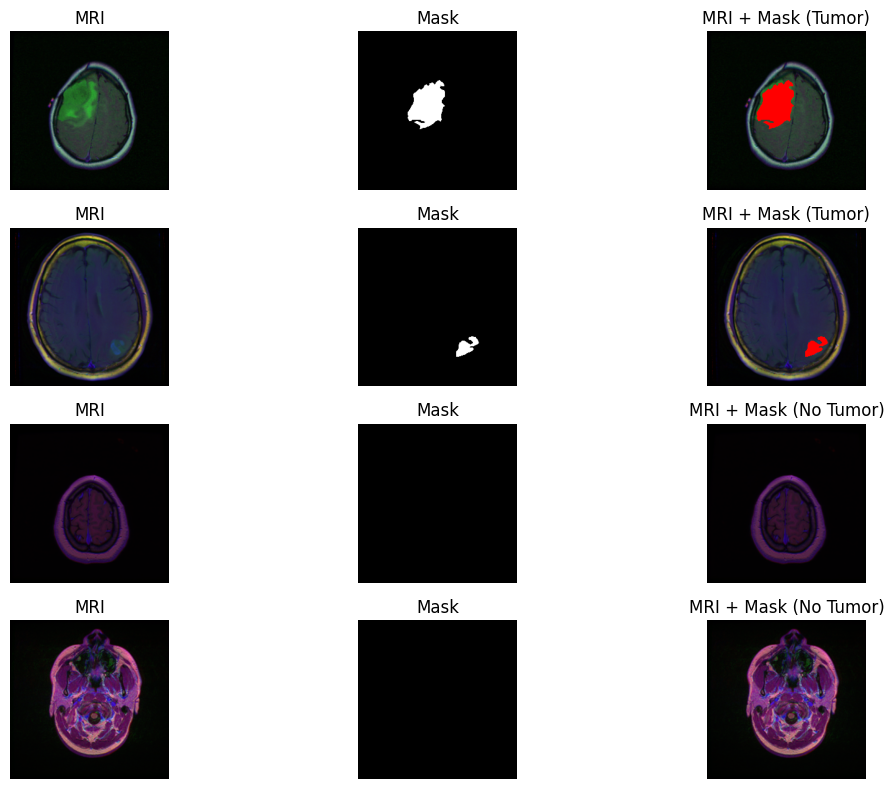

In [ ]:
# Selecting random 2 tumor and 2 no-tumor cases
dfTumor = df[df['hasTumor'] == 1].sample(2).reset_index(drop=True)
dfNoTumor = df[df['hasTumor'] == 0].sample(2).reset_index(drop=True)
samples = pd.concat([dfTumor, dfNoTumor]).reset_index(drop=True)

plt.figure(figsize=(12,8))

# For each of the samples vizualise the mri, mask, and the mri+mask
for i in range(4):
    img = cv2.imread(samples.loc[i, 'imgPath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(samples.loc[i, 'mskPath'], cv2.IMREAD_GRAYSCALE)

    # showing  scan
    plt.subplot(4, 3, i*3+1)
    plt.imshow(img)
    plt.title('MRI')
    plt.axis('off')

    # shing the mask of the tumor
    plt.subplot(4, 3, i*3+2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    # mri scan with mask on top
    overlay = img.copy()
    overlay[mask == 255] = [255, 0, 0]
    plt.subplot(4, 3, i*3+3)
    plt.imshow(overlay)
    label = 'Tumor' if samples.loc[i, 'hasTumor'] == 1 else 'No Tumor'
    plt.title(f'MRI + Mask ({label})')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# tumor and no tumor counts
tcnts = df['hasTumor'].value_counts()
noTumor = tcnts[0]
yesTumor = tcnts[1]
total = noTumor + yesTumor
print(f"No Tumor: {noTumor}")
print(f"Tumor Present: {yesTumor}")
print(f"Total Images: {total}")
print(f"Class Balance Ratio (Tumor/Total): {yesTumor/total:.2f}")

# check if imbalance is high
if yesTumor / total < 0.3:
    print("Dataset is imbalanced.")
else:
    print("Dataset is balanced")


No Tumor: 2556
Tumor Present: 1373
Total Images: 3929
Class Balance Ratio (Tumor/Total): 0.35
Dataset is balanced


In [ ]:
from sklearn.model_selection import train_test_split
# df to only rows that have tumour detected because tumor segmentation is applied only when theres a tumour
df_t = df[df['hasTumor'] == 1].copy()

# Split dataset to 70, 30 split 70 for train 30 for test and val
df_train, df_temp = train_test_split(df_t, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

# Print split info
print("Train set size:", len(df_train))
print("Validation set size:", len(df_val))
print("Test set size:", len(df_test))

Train set size: 961
Validation set size: 206
Test set size: 206


In [ ]:

# Function that loads and preprocesses all the images and masks
def load_data(imgpths, mskpths, height=256, width=256):
    # Create empty numpy arrays X and Y which stores images, masks with shape number of samples, height, width, channels)
    x = np.empty((len(imgpths), height, width, 3), dtype=np.float32)
    y = np.empty((len(mskpths), height, width, 1), dtype=np.float32)

    # Loop through each image and mask
    for i in tqdm(range(len(imgpths)), desc="Loading data"):
        # read and resize image
        img = io.imread(imgpths[i])
        img = cv2.resize(img, (width, height)) # resize image to 256,256
        # standardise the image pixel values so its nornmalised
        img = (img - np.mean(img)) / np.std(img)
        x[i] = img

        # read and resize mask
        mask = io.imread(mskpths[i], as_gray=True)
        mask = cv2.resize(mask, (width, height))
        mask = (mask - np.mean(mask)) / np.std(mask)
        # Adding extra dimension to the mask as it needs to match image shape
        mask = np.expand_dims(mask, axis=-1)
        #  check the mask values > 0 become 1 as tumor else 0
        y[i] = (mask > 0).astype(np.float32)
    return x, y

# reading the training, validation, and test datasets using the load_data function
X_train, y_train = load_data(df_train['imgPath'].tolist(), df_train['mskPath'].tolist())
X_val,   y_val   = load_data(df_val['imgPath'].tolist(),   df_val['mskPath'].tolist())
X_test,  y_test  = load_data(df_test['imgPath'].tolist(),  df_test['mskPath'].tolist())

Loading data: 100%|██████████| 206/206 [00:45<00:00,  4.54it/s]


In [ ]:
# function that adds a shortcut connection to help improve gradient flow
def res_block(x, filters):
    shortcut = x
    # first convolutional layer
    x = Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second convolutional layer
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # changing shortcut to match the number of filters
    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(shortcut)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# upsampling function with skip connections which combines upsampled feature maps with feature maps from the encoder
def upsample_block(x, skip, filters):
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip])
    x = res_block(x, filters)
    return x

# ResUNet model function
def build_resunet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    # initial layers
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # layer 2 with residual connection
    conv2 = res_block(pool1, 32)
    pool2 = MaxPooling2D((2, 2))(conv2)
    # layer 3 that has residual connection
    conv3 = res_block(pool2, 64)
    pool3 = MaxPooling2D((2, 2))(conv3)
    # layer 4
    conv4 = res_block(pool3, 128)
    pool4 = MaxPooling2D((2, 2))(conv4)
    conv5 = res_block(pool4, 256)
    # Upsampling layers
    up6 = upsample_block(conv5, conv4, 128)
    up7 = upsample_block(up6, conv3, 64)
    up8 = upsample_block(up7, conv2, 32)
    up9 = upsample_block(up8, conv1, 16)

    # final output layer which is a 1x1 convolution with sigmoid activation for binary segmentation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up9)
    model = Model(inputs=inputs, outputs=outputs)
    return model
resunet_model = build_resunet()
resunet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d_1[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

In [ ]:

# tversky loss function as dataset has slight imbalancement so tversky loss takes this into accoutn to provide unbiased results
def tversky(y_t, y_p, alpha=0.7, smooth=1e-6):
    y_t = K.flatten(y_t)
    y_p = K.flatten(y_p)

    true_pos  = K.sum(y_t * y_p)
    false_neg = K.sum(y_t * (1 - y_p))
    false_pos = K.sum((1 - y_t) * y_p)

    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

# focal tversky loss function enforces learning on harder pixels and help avoid lazy predictions
def focal_tversky(y_t, y_p, gamma=0.75):
    pt = tversky(y_t, y_p)
    return K.pow((1 - pt), gamma)

# compiling model
resunet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_tversky,
    metrics=[tversky]
)

In [ ]:
# early stopping to stop training if validation loss doesn't improve helps increase performence as I have less GPU space
e_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# save best model weights to a file so can use when uploading model to website
cp = ModelCheckpoint('ResUNet.h5', save_best_only=True, verbose=1)

# reduce the LR when val loss gets worse
reduc = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-6, verbose=1)

# train model
model = resunet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=60,
    callbacks=[e_stop, cp, reduc]
)


Epoch 1/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.8498 - tversky: 0.1939
Epoch 1: val_loss improved from inf to 0.80132, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 139ms/step - loss: 0.8494 - tversky: 0.1945 - val_loss: 0.8013 - val_tversky: 0.2543 - learning_rate: 1.0000e-04
Epoch 2/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6888 - tversky: 0.3893
Epoch 2: val_loss improved from 0.80132 to 0.64318, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.6875 - tversky: 0.3908 - val_loss: 0.6432 - val_tversky: 0.4420 - learning_rate: 1.0000e-04
Epoch 3/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5744 - tversky: 0.5200
Epoch 3: val_loss improved from 0.64318 to 0.55259, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.5743 - tversky: 0.5202 - val_loss: 0.5526 - val_tversky: 0.5426 - learning_rate: 1.0000e-04
Epoch 4/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5177 - tversky: 0.5818
Epoch 4: val_loss improved from 0.55259 to 0.53444, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.5175 - tversky: 0.5820 - val_loss: 0.5344 - val_tversky: 0.5621 - learning_rate: 1.0000e-04
Epoch 5/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4840 - tversky: 0.6168
Epoch 5: val_loss improved from 0.53444 to 0.49211, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.4840 - tversky: 0.6168 - val_loss: 0.4921 - val_tversky: 0.6072 - learning_rate: 1.0000e-04
Epoch 6/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4535 - tversky: 0.6488
Epoch 6: val_loss improved from 0.49211 to 0.47556, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.4534 - tversky: 0.6489 - val_loss: 0.4756 - val_tversky: 0.6241 - learning_rate: 1.0000e-04
Epoch 7/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4388 - tversky: 0.6639
Epoch 7: val_loss improved from 0.47556 to 0.45708, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.4381 - tversky: 0.6646 - val_loss: 0.4571 - val_tversky: 0.6426 - learning_rate: 1.0000e-04
Epoch 8/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3952 - tversky: 0.7078
Epoch 8: val_loss improved from 0.45708 to 0.44921, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.3951 - tversky: 0.7079 - val_loss: 0.4492 - val_tversky: 0.6516 - learning_rate: 1.0000e-04
Epoch 9/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3771 - tversky: 0.7248
Epoch 9: val_loss improved from 0.44921 to 0.42328, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.3770 - tversky: 0.7249 - val_loss: 0.4233 - val_tversky: 0.6781 - learning_rate: 1.0000e-04
Epoch 10/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3618 - tversky: 0.7397
Epoch 10: val_loss did not improve from 0.42328
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3618 - tversky: 0.7397 - val_loss: 0.4852 - val_tversky: 0.6131 - learning_rate: 1.0000e-04
Epoch 11/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3432 - tversky: 0.7560
Epoch 11: val_loss improved from 0.42328 to 0.40030, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.3431 - tversky: 0.7561 - val_loss: 0.4003 - val_tversky: 0.7000 - learning_rate: 1.0000e-04
Epoch 12/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3199 - tversky: 0.7793
Epoch 12: val_loss did not improve from 0.40030
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3202 - tversky: 0.7790 - val_loss: 0.4087 - val_tversky: 0.6915 - learning_rate: 1.0000e-04
Epoch 13/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3247 - tversky: 0.7740
Epoch 13: val_loss improved from 0.40030 to 0.39667, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.3244 - tversky: 0.7743 - val_loss: 0.3967 - val_tversky: 0.7035 - learning_rate: 1.0000e-04
Epoch 14/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2921 - tversky: 0.8047
Epoch 14: val_loss did not improve from 0.39667
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2923 - tversky: 0.8045 - val_loss: 0.4077 - val_tversky: 0.6931 - learning_rate: 1.0000e-04
Epoch 15/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2882 - tversky: 0.8076
Epoch 15: val_loss improved from 0.39667 to 0.38779, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2881 - tversky: 0.8077 - val_loss: 0.3878 - val_tversky: 0.7130 - learning_rate: 1.0000e-04
Epoch 16/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2810 - tversky: 0.8138
Epoch 16: val_loss did not improve from 0.38779
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2809 - tversky: 0.8138 - val_loss: 0.4120 - val_tversky: 0.6880 - learning_rate: 1.0000e-04
Epoch 17/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2670 - tversky: 0.8262
Epoch 17: val_loss improved from 0.38779 to 0.38278, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2673 - tversky: 0.8259 - val_loss: 0.3828 - val_tversky: 0.7175 - learning_rate: 1.0000e-04
Epoch 18/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2670 - tversky: 0.8267
Epoch 18: val_loss did not improve from 0.38278
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2670 - tversky: 0.8267 - val_loss: 0.4204 - val_tversky: 0.6798 - learning_rate: 1.0000e-04
Epoch 19/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2716 - tversky: 0.8220
Epoch 19: val_loss improved from 0.38278 to 0.37898, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.2713 - tversky: 0.8223 - val_loss: 0.3790 - val_tversky: 0.7207 - learning_rate: 1.0000e-04
Epoch 20/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2586 - tversky: 0.8333
Epoch 20: val_loss improved from 0.37898 to 0.37621, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.2584 - tversky: 0.8334 - val_loss: 0.3762 - val_tversky: 0.7234 - learning_rate: 1.0000e-04
Epoch 21/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2569 - tversky: 0.8342
Epoch 21: val_loss did not improve from 0.37621
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2567 - tversky: 0.8344 - val_loss: 0.3836 - val_tversky: 0.7172 - learning_rate: 1.0000e-04
Epoch 22/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2455 - tversky: 0.8442
Epoch 22: val_loss improved from 0.37621 to 0.37582, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2453 - tversky: 0.8443 - val_loss: 0.3758 - val_tversky: 0.7229 - learning_rate: 1.0000e-04
Epoch 23/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2410 - tversky: 0.8485
Epoch 23: val_loss did not improve from 0.37582
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2409 - tversky: 0.8486 - val_loss: 0.3808 - val_tversky: 0.7191 - learning_rate: 1.0000e-04
Epoch 24/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2264 - tversky: 0.8604
Epoch 24: val_loss did not improve from 0.37582
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2265 - tversky: 0.8603 - val_loss: 0.3788 - val_tversky: 0.7203 - learning_rate: 1.0000e-04
Epoch 25/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2322 - tversky: 0.8558
Epoch 25: val_loss improved from 0.37582 to 0.36819, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2320 - tversky: 0.8559 - val_loss: 0.3682 - val_tversky: 0.7309 - learning_rate: 1.0000e-04
Epoch 26/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2158 - tversky: 0.8698
Epoch 26: val_loss did not improve from 0.36819
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2159 - tversky: 0.8696 - val_loss: 0.4161 - val_tversky: 0.6841 - learning_rate: 1.0000e-04
Epoch 27/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2211 - tversky: 0.8646
Epoch 27: val_loss did not improve from 0.36819
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2210 - tversky: 0.8646 - val_loss: 0.3910 - val_tversky: 0.7084 - learning_rate: 1.0000e-04
Epoch 28/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2124 - tversky: 0.8723
Epoch 28: val_loss improved from 0.36819 to 0.36013, saving model to ResUNet.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.2123 - tversky: 0.8724 - val_loss: 0.3601 - val_tversky: 0.7384 - learning_rate: 1.0000e-04
Epoch 29/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2134 - tversky: 0.8709
Epoch 29: val_loss did not improve from 0.36013
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2132 - tversky: 0.8710 - val_loss: 0.3782 - val_tversky: 0.7208 - learning_rate: 1.0000e-04
Epoch 30/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2043 - tversky: 0.8787
Epoch 30: val_loss did not improve from 0.36013
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2042 - tversky: 0.8788 - val_loss: 0.3725 - val_tversky: 0.7265 - learning_rate: 1.0000e-04
Epoch 31/60
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1931 - tversky: 0.8874
Epoch 31: val_loss did not improve from 0.36013
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1933 - tversky: 0.8872 - val_loss: 0.3819 - val_tversky: 0.7175 - learning_rate: 1.0000e-04
Epoch 32/60
118/121

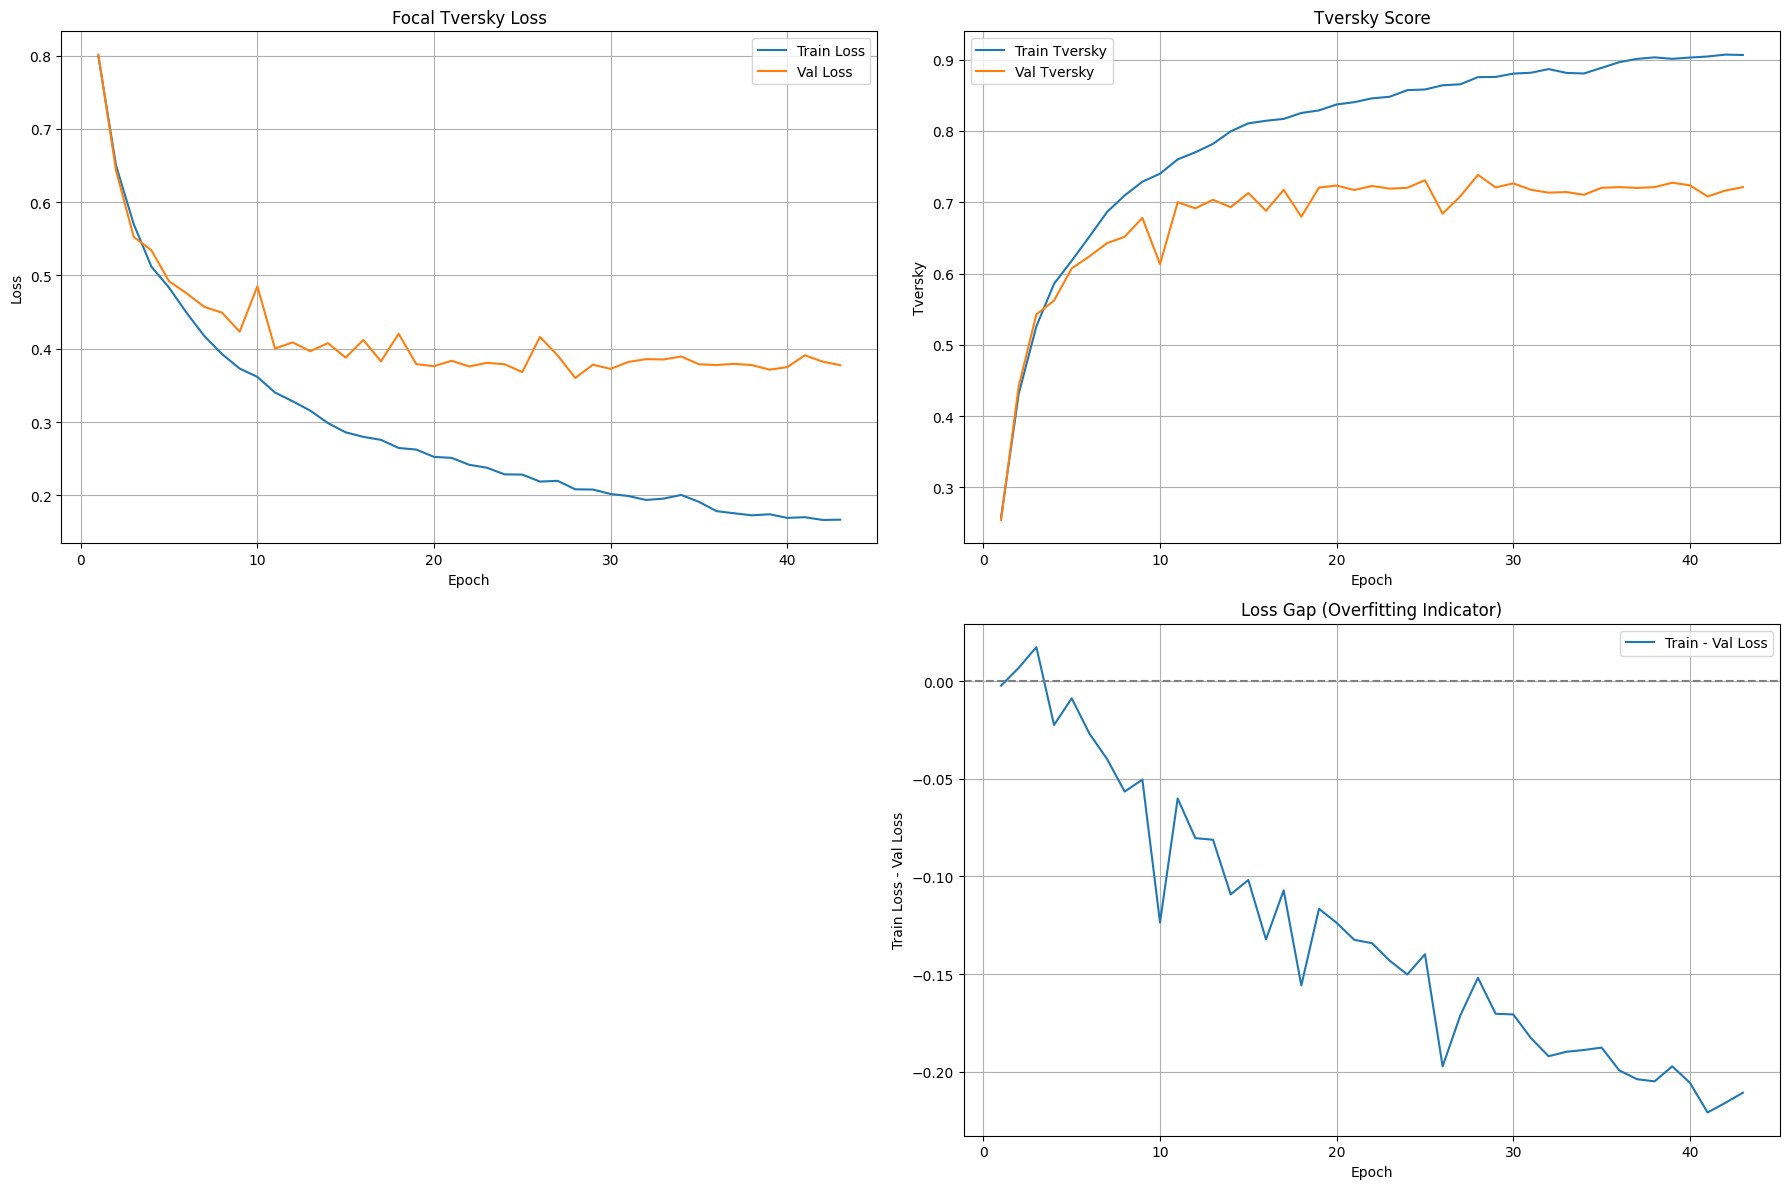

In [ ]:
loss = model.history['loss']
val_loss = model.history['val_loss']
tversky = model.history['tversky']
val_tversky = model.history['val_tversky']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(18, 12))

# Loss Curve
plt.subplot(2, 2, 1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Focal Tversky Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Tversky Score Curve
plt.subplot(2, 2, 2)
plt.plot(epochs, tversky, label='Train Tversky')
plt.plot(epochs, val_tversky, label='Val Tversky')
plt.title('Tversky Score')
plt.xlabel('Epoch')
plt.ylabel('Tversky')
plt.legend()
plt.grid(True)

# Train - Val Loss Gap
plt.subplot(2, 2, 4)
loss_gap = np.array(loss) - np.array(val_loss)
plt.plot(epochs, loss_gap, label='Train - Val Loss')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Loss Gap (Overfitting Indicator)')
plt.xlabel('Epoch')
plt.ylabel('Train Loss - Val Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def scores(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)  # predict mask probabilities 0 to 1
    y_pred_masks = (y_pred > 0.5).astype(np.uint8)  # Threshold at 0.5 so if above 0.5 classed as 1 which is tumour

    #flatten arrays so can compare pixel by pixel and make both prediction and ground truth to 1d arrays as metrics need 1d arrays
    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred_masks.flatten()

    #converting arrays to binary
    y_true_bin = (y_true_flat > 0).astype(np.uint8)
    y_pred_bin = (y_pred_flat > 0).astype(np.uint8)

    acc = accuracy_score(y_true_bin, y_pred_bin)
    f1 = f1_score(y_true_bin, y_pred_bin)
    iou = jaccard_score(y_true_bin, y_pred_bin)

    print(f"\n{model_name} Segmentation Performance:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Dice     : {f1:.4f}")
    print(f"IoU      : {iou:.4f}")

    return acc, f1, iou, y_pred_masks

In [ ]:
_, _, _, y_pred_test = scores(resunet_model, X_test, y_test, model_name="ResUNet")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

ResUNet Segmentation Performance:
Accuracy : 0.9839
Dice     : 0.7686
IoU      : 0.6242


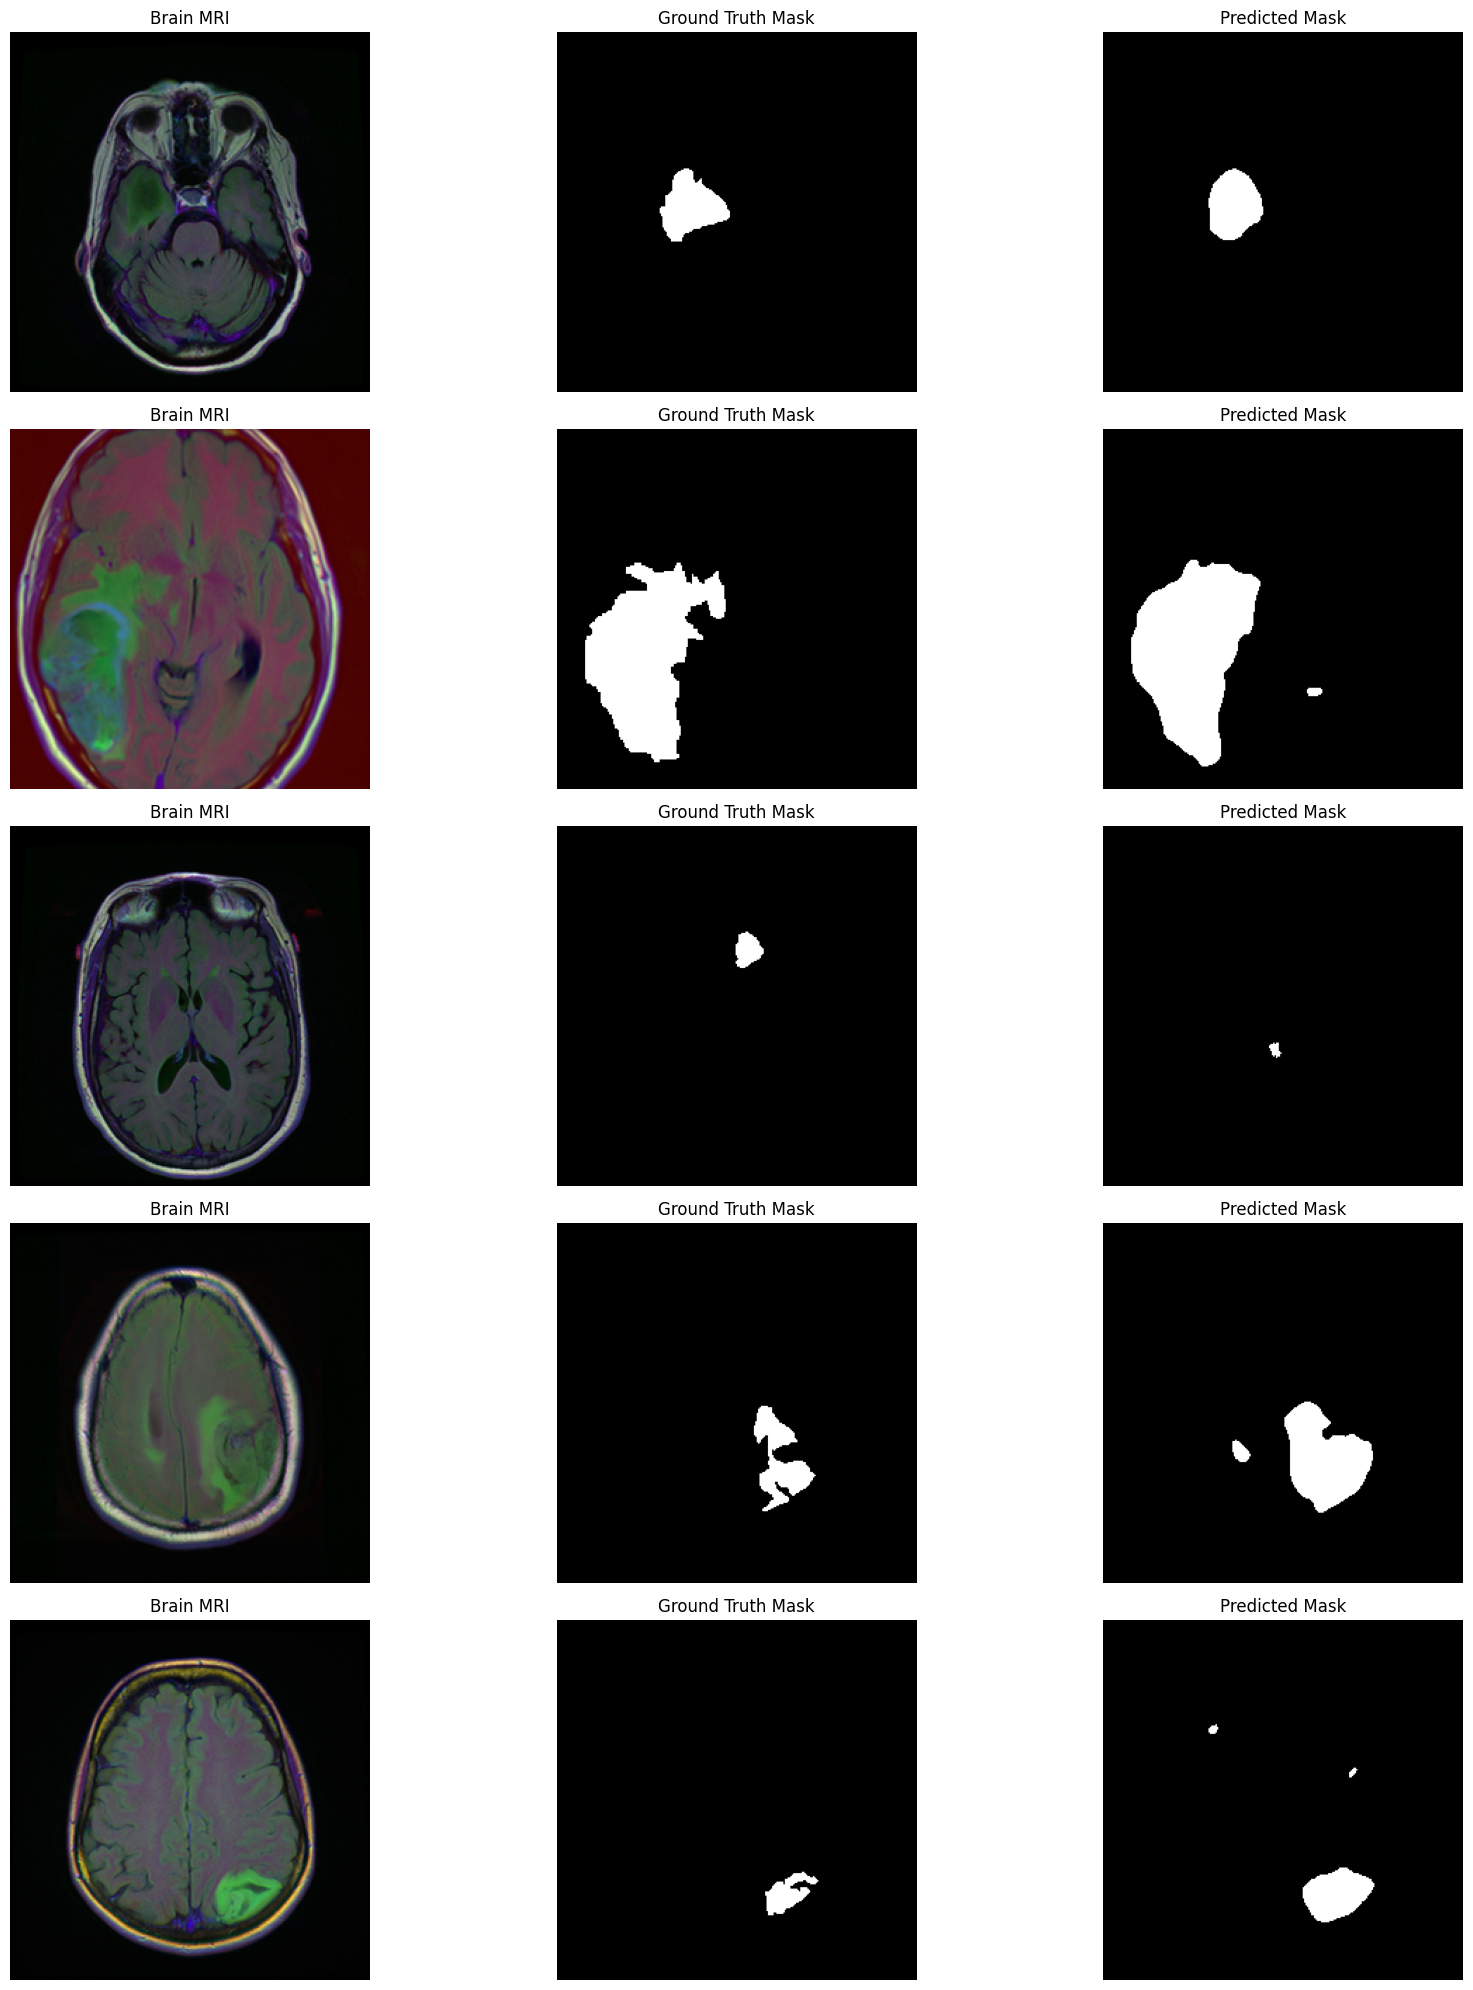

In [ ]:
n_samples = 5
plt.figure(figsize=(18, n_samples * 4))

for i in range(n_samples):
    # select sample
    img = X_test[i]
    true_mask = y_test[i].squeeze()
    pred_mask = y_pred_test[i].squeeze()

    # row index in plot
    row = i * 3

    # Scale image for correct display
    display_img = (img - img.min()) / (img.max() - img.min())

    # original MRI
    plt.subplot(n_samples, 3, row + 1)
    plt.imshow(display_img)
    plt.title("Brain MRI")
    plt.axis('off')

    # ground truth mask
    plt.subplot(n_samples, 3, row + 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(n_samples, 3, row + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# save model to json
model_json = resunet_model.to_json()
with open("ResUNet_model.json", "w") as json_file:
    json_file.write(model_json)

# save model weights
resunet_model.save_weights("ResUNet_weights.weights.h5")
print("Model architecture and weights saved.")

Model architecture and weights saved.


In [ ]:
# load model
with open("ResUNet_model.json", "r") as json_file:
    modeljson = json_file.read()

# provide custom objects when loading the model
custom_objects = {'focal_tversky': focal_tversky, 'tversky': tversky}
resunetmodel = model_from_json(modeljson, custom_objects=custom_objects)

# load weights
resunetmodel.load_weights("ResUNet_weights.weights.h5")

# compile with same settings as when trained
resunetmodel.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_tversky,
    metrics=[tversky]
)

print("Model loaded and compiled.")

Model loaded and compiled.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 108 variables whereas the saved optimizer has 214 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


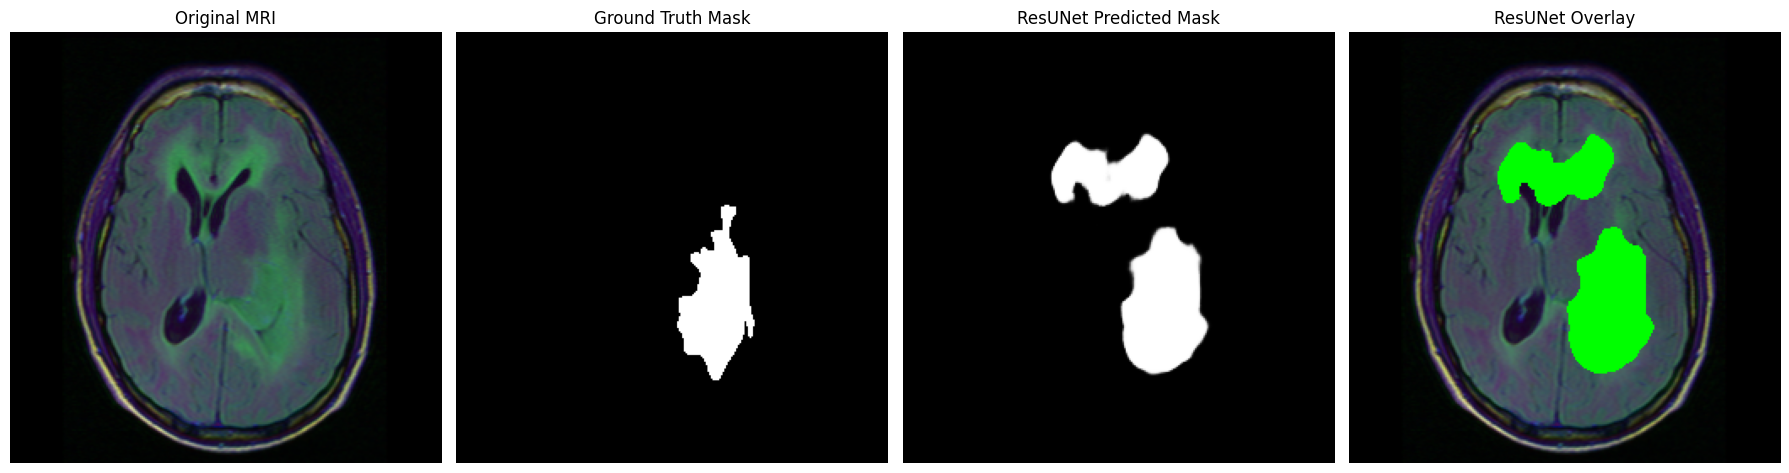

In [ ]:
def show_segmentation(img_path, mask_path, model, height=256, width=256, model_name="Model"):
    # read and resize mri image
    img = io.imread(img_path)
    imgresize = cv2.resize(img, (width, height))

    # read and resize ground truth mask
    gt_mask = io.imread(mask_path, as_gray=True)
    gt_mask = cv2.resize(gt_mask, (width, height))
    gt_bin_mask = (gt_mask > 0).astype(np.uint8)  # convert mask to binary 0 or 1 1 if tumour

    # normalise MRI image and expand dims for model input
    imginp = (imgresize - np.mean(imgresize)) / np.std(imgresize)
    imginp = np.expand_dims(imginp, axis=0)

    # predict tumor mask with model
    pred_mask = model.predict(imginp)[0].squeeze()
    bin_mask = (pred_mask > 0.5).astype(np.uint8)  # binarise with threshold > 0.5 so if >0.5 then will be 1 meaning tumour

    # create overlay for predicted mask green
    overlay_pred = imgresize.copy()
    overlay_pred[bin_mask == 1] = [0, 255, 0]

    # create overlay for ground truth mask red = true tumor
    overlay_gt = imgresize.copy()
    overlay_gt[gt_bin_mask == 1] = [255, 0, 0]

    # plot results
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(imgresize.astype(np.uint8))
    plt.title("Original MRI")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(gt_bin_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title(f"{model_name} Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(overlay_pred.astype(np.uint8))
    plt.title(f"{model_name} Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

mri_topredict = "/content/drive/MyDrive/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_12.tif"
maskgroundtruth = '/content/drive/MyDrive/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_12_mask.tif'
show_segmentation(mri_topredict,maskgroundtruth, resunetmodel, model_name='ResUNet')



In [ ]:

def tversky(y_t, y_p, alpha=0.7, smooth=1e-6):
    y_t = K.flatten(y_t)
    y_p = K.flatten(y_p)

    true_pos = K.sum(y_t * y_p)
    false_neg = K.sum(y_t * (1 - y_p))
    false_pos = K.sum((1 - y_t) * y_p)

    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def focal_tversky(y_t, y_p, gamma=0.75):
    pt = tversky(y_t, y_p)
    return K.pow((1 - pt), gamma)


In [ ]:
def DeeplabV3(image_size=256, num_classes=1):
    model_input = layers.Input(shape=(image_size, image_size, 3))

    # use pretrained Xception as backbone from keras
    backbone = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_tensor=model_input
    )
    # Atrous spatial pyramid pooling
    x4 = layers.GlobalAveragePooling2D()(backbone.output)
    x4 = layers.Reshape((1, 1, x4.shape[-1]))(x4)
    x4 = layers.Conv2D(256, 1, padding='same', use_bias=False)(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Activation('relu')(x4)
    x4 = layers.UpSampling2D(
        size=(8, 8),
        interpolation='bilinear')(x4)
    x0 = layers.Conv2D(256, 1, padding='same', use_bias=False)(backbone.output)
    x0 = layers.BatchNormalization()(x0)
    x0 = layers.Activation('relu')(x0)
    x1 = layers.Conv2D(256, 3, dilation_rate=6, padding='same', use_bias=False)(backbone.output)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x2 = layers.Conv2D(256, 3, dilation_rate=12, padding='same', use_bias=False)(backbone.output)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x3 = layers.Conv2D(256, 3, dilation_rate=18, padding='same', use_bias=False)(backbone.output)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Activation('relu')(x3)
    x = layers.Concatenate()([x4, x0, x1, x2, x3])
    x = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(x)
    # decoder layers
    # use block2_sepconv2_act for low-level features to make more efficent and resize to 64x64
    low = backbone.get_layer('block2_sepconv2_act').output
    low = layers.Conv2D(256, 1, padding='same', use_bias=False)(low)
    low = layers.BatchNormalization()(low)
    low = layers.Activation('relu')(low)
    # resize low-level features using keras Layer
    low = layers.Resizing(64, 64, interpolation='bilinear')(low)
    x = layers.Concatenate()([x, low])
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    model_output = layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x)
    return Model(inputs=model_input, outputs=model_output)

# create the model
deeplab_model = DeeplabV3(image_size=256, num_classes=1)

# compile the model
deeplab_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_tversky,
    metrics=[tversky]
)

deeplab_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 127, 127,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 127, 127,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 127, 127,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 125, 125,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 125, 125,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 125, 125,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 125, 125,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 125, 125,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 125, 125,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 125, 125,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 125, 125,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 63, 63,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 63, 63,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 63, 63,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 63, 63,    │          0 │ add_20[0][0]    

 Total params: 38,205,225 (145.74 MB)

 Trainable params: 38,146,089 (145.52 MB)

 Non-trainable params: 59,136 (231.00 KB)

In [ ]:
# early stopping and setting checkpoints to improve efficiency as if model starts to get worse during training it will stop and return the last best model

e_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
cp = ModelCheckpoint('DeepLabV3Plus.h5', save_best_only=True, verbose=1)
reduc = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-6, verbose=1)


# Train DeepLabV3+ model using the loaded data arrays
model2 = deeplab_model.fit(
    X_train, y_train,
    epochs=60,
    validation_data=(X_val, y_val),
    batch_size=8,
    callbacks=[cp, e_stop, reduc]
)


Epoch 1/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.7309 - tversky: 0.3377
Epoch 1: val_loss improved from inf to 0.64226, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 118s 401ms/step - loss: 0.7301 - tversky: 0.3386 - val_loss: 0.6423 - val_tversky: 0.4425 - learning_rate: 1.0000e-04
Epoch 2/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.4437 - tversky: 0.6577
Epoch 2: val_loss improved from 0.64226 to 0.41559, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.4435 - tversky: 0.6579 - val_loss: 0.4156 - val_tversky: 0.6846 - learning_rate: 1.0000e-04
Epoch 3/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3577 - tversky: 0.7431
Epoch 3: val_loss improved from 0.41559 to 0.38155, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.3578 - tversky: 0.7430 - val_loss: 0.3815 - val_tversky: 0.7177 - learning_rate: 1.0000e-04
Epoch 4/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3473 - tversky: 0.7513
Epoch 4: val_loss improved from 0.38155 to 0.37627, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.3472 - tversky: 0.7514 - val_loss: 0.3763 - val_tversky: 0.7214 - learning_rate: 1.0000e-04
Epoch 5/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3237 - tversky: 0.7749
Epoch 5: val_loss improved from 0.37627 to 0.35257, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.3236 - tversky: 0.7751 - val_loss: 0.3526 - val_tversky: 0.7463 - learning_rate: 1.0000e-04
Epoch 6/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2993 - tversky: 0.7968
Epoch 6: val_loss did not improve from 0.35257
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2993 - tversky: 0.7967 - val_loss: 0.3882 - val_tversky: 0.7102 - learning_rate: 1.0000e-04
Epoch 7/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2937 - tversky: 0.8021
Epoch 7: val_loss did not improve from 0.35257
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.2936 - tversky: 0.8021 - val_loss: 0.3584 - val_tversky: 0.7389 - learning_rate: 1.0000e-04
Epoch 8/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2786 - tversky: 0.8153
Epoch 8: val_loss improved from 0.35257 to 0.34146, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.2785 - tversky: 0.8154 - val_loss: 0.3415 - val_tversky: 0.7549 - learning_rate: 1.0000e-04
Epoch 9/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2784 - tversky: 0.8163
Epoch 9: val_loss improved from 0.34146 to 0.33188, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.2783 - tversky: 0.8164 - val_loss: 0.3319 - val_tversky: 0.7655 - learning_rate: 1.0000e-04
Epoch 10/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2560 - tversky: 0.8356
Epoch 10: val_loss did not improve from 0.33188
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2561 - tversky: 0.8356 - val_loss: 0.3629 - val_tversky: 0.7344 - learning_rate: 1.0000e-04
Epoch 11/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2528 - tversky: 0.8384
Epoch 11: val_loss did not improve from 0.33188
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.2527 - tversky: 0.8385 - val_loss: 0.3332 - val_tversky: 0.7638 - learning_rate: 1.0000e-04
Epoch 12/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2547 - tversky: 0.8362
Epoch 12: val_loss improved from 0.33188 to 0.32917, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.2545 - tversky: 0.8363 - val_loss: 0.3292 - val_tversky: 0.7668 - learning_rate: 1.0000e-04
Epoch 13/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2461 - tversky: 0.8439
Epoch 13: val_loss improved from 0.32917 to 0.32886, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.2460 - tversky: 0.8439 - val_loss: 0.3289 - val_tversky: 0.7676 - learning_rate: 1.0000e-04
Epoch 14/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2531 - tversky: 0.8378
Epoch 14: val_loss did not improve from 0.32886
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2531 - tversky: 0.8377 - val_loss: 0.3344 - val_tversky: 0.7608 - learning_rate: 1.0000e-04
Epoch 15/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2300 - tversky: 0.8579
Epoch 15: val_loss did not improve from 0.32886
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2301 - tversky: 0.8578 - val_loss: 0.3388 - val_tversky: 0.7567 - learning_rate: 1.0000e-04
Epoch 16/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2332 - tversky: 0.8550
Epoch 16: val_loss improved from 0.32886 to 0.32425, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.2332 - tversky: 0.8549 - val_loss: 0.3242 - val_tversky: 0.7715 - learning_rate: 1.0000e-04
Epoch 17/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2255 - tversky: 0.8614
Epoch 17: val_loss did not improve from 0.32425
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2256 - tversky: 0.8614 - val_loss: 0.3364 - val_tversky: 0.7593 - learning_rate: 1.0000e-04
Epoch 18/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2215 - tversky: 0.8646
Epoch 18: val_loss did not improve from 0.32425
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.2215 - tversky: 0.8646 - val_loss: 0.3299 - val_tversky: 0.7657 - learning_rate: 1.0000e-04
Epoch 19/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2223 - tversky: 0.8638
Epoch 19: val_loss did not improve from 0.32425
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2222 - tversky: 0.8639 - val_loss: 0.3247 - val_tversky: 0.7704 - learning_rate: 1.0000e-04
Epoch 20/60
120/12

121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.2233 - tversky: 0.8632 - val_loss: 0.3169 - val_tversky: 0.7783 - learning_rate: 1.0000e-04
Epoch 21/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2016 - tversky: 0.8805
Epoch 21: val_loss did not improve from 0.31686
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2018 - tversky: 0.8804 - val_loss: 0.3264 - val_tversky: 0.7688 - learning_rate: 1.0000e-04
Epoch 22/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2141 - tversky: 0.8705
Epoch 22: val_loss did not improve from 0.31686
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.2141 - tversky: 0.8705 - val_loss: 0.3662 - val_tversky: 0.7313 - learning_rate: 1.0000e-04
Epoch 23/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2157 - tversky: 0.8695
Epoch 23: val_loss improved from 0.31686 to 0.31103, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.2156 - tversky: 0.8694 - val_loss: 0.3110 - val_tversky: 0.7831 - learning_rate: 1.0000e-04
Epoch 24/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2065 - tversky: 0.8760
Epoch 24: val_loss did not improve from 0.31103
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2066 - tversky: 0.8759 - val_loss: 0.3111 - val_tversky: 0.7833 - learning_rate: 1.0000e-04
Epoch 25/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2031 - tversky: 0.8790
Epoch 25: val_loss did not improve from 0.31103
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.2031 - tversky: 0.8789 - val_loss: 0.3505 - val_tversky: 0.7458 - learning_rate: 1.0000e-04
Epoch 26/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1931 - tversky: 0.8874
Epoch 26: val_loss did not improve from 0.31103
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.1932 - tversky: 0.8874 - val_loss: 0.3115 - val_tversky: 0.7821 - learning_rate: 1.0000e-04
Epoch 27/60
120/12

121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.1943 - tversky: 0.8859 - val_loss: 0.3091 - val_tversky: 0.7845 - learning_rate: 3.0000e-05
Epoch 32/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1785 - tversky: 0.8986
Epoch 32: val_loss did not improve from 0.30908
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.1785 - tversky: 0.8986 - val_loss: 0.3103 - val_tversky: 0.7833 - learning_rate: 3.0000e-05
Epoch 33/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1607 - tversky: 0.9117
Epoch 33: val_loss did not improve from 0.30908
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.1610 - tversky: 0.9114 - val_loss: 0.3166 - val_tversky: 0.7777 - learning_rate: 3.0000e-05
Epoch 34/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1666 - tversky: 0.9077
Epoch 34: val_loss did not improve from 0.30908
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.1667 - tversky: 0.9076 - val_loss: 0.3091 - val_tversky: 0.7847 - learning_rate: 3.0000e-05
Epoch 35/60
120/12

121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.1780 - tversky: 0.8980 - val_loss: 0.3085 - val_tversky: 0.7852 - learning_rate: 3.0000e-05
Epoch 38/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1718 - tversky: 0.9034
Epoch 38: val_loss did not improve from 0.30853
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.1717 - tversky: 0.9035 - val_loss: 0.3154 - val_tversky: 0.7791 - learning_rate: 3.0000e-05
Epoch 39/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1707 - tversky: 0.9042
Epoch 39: val_loss improved from 0.30853 to 0.30677, saving model to DeepLabV3Plus.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.1707 - tversky: 0.9042 - val_loss: 0.3068 - val_tversky: 0.7871 - learning_rate: 3.0000e-05
Epoch 40/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1741 - tversky: 0.9016
Epoch 40: val_loss did not improve from 0.30677
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.1741 - tversky: 0.9016 - val_loss: 0.3246 - val_tversky: 0.7706 - learning_rate: 3.0000e-05
Epoch 41/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1684 - tversky: 0.9059
Epoch 41: val_loss did not improve from 0.30677
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.1684 - tversky: 0.9059 - val_loss: 0.3106 - val_tversky: 0.7835 - learning_rate: 3.0000e-05
Epoch 42/60
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1725 - tversky: 0.9027
Epoch 42: val_loss did not improve from 0.30677
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.1725 - tversky: 0.9026 - val_loss: 0.3072 - val_tversky: 0.7865 - learning_rate: 3.0000e-05
Epoch 43/60
120/12

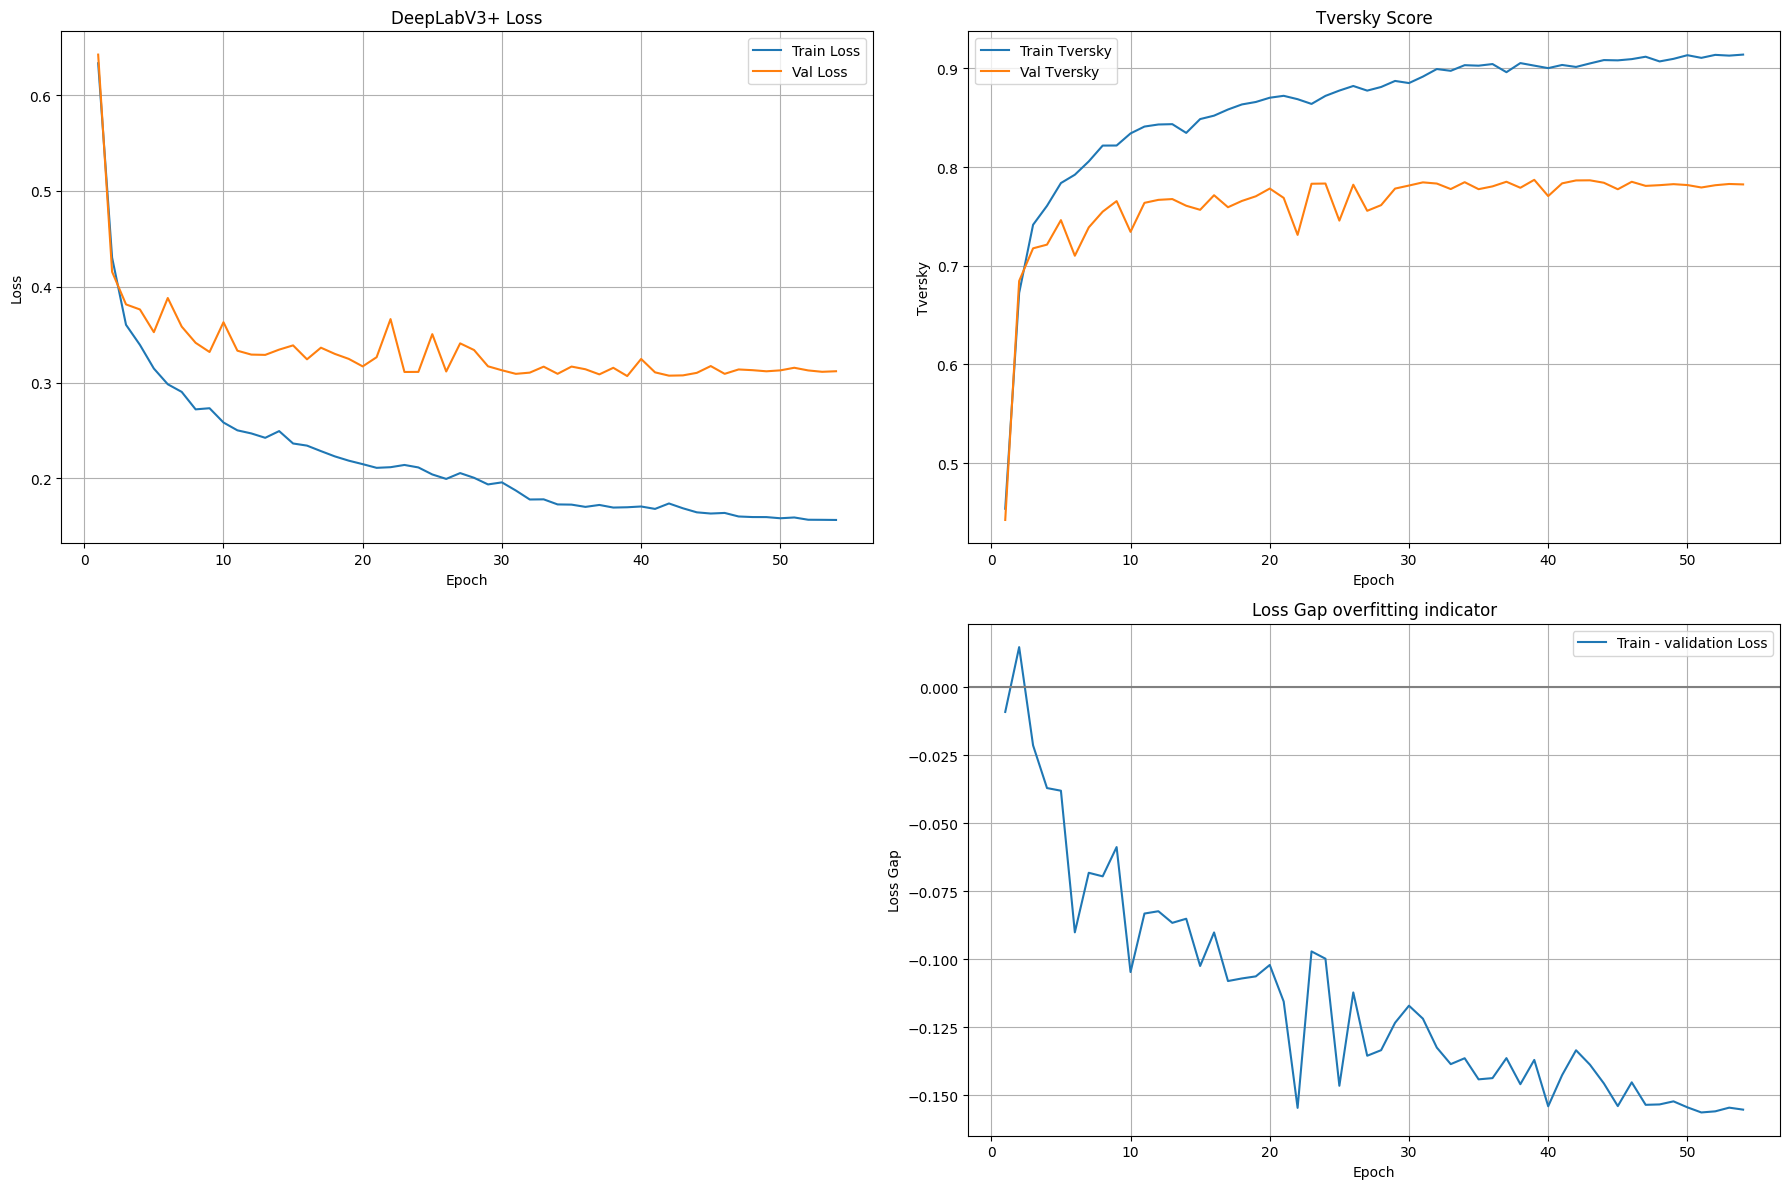

In [ ]:


# extract and save metrics from training
loss = model2.history['loss']
val_loss = model2.history['val_loss']
tversky_train = model2.history['tversky']
tversky_val = model2.history['val_tversky']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(18, 12))

# plotting loss Curve
plt.subplot(2, 2, 1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('DeepLabV3+ Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# plotting tversky score curve
plt.subplot(2, 2, 2)
plt.plot(epochs, tversky_train, label='Train Tversky')
plt.plot(epochs, tversky_val, label='Val Tversky')
plt.title('Tversky Score')
plt.xlabel('Epoch')
plt.ylabel('Tversky')
plt.legend()
plt.grid(True)


# loss gap helps see overfitting
plt.subplot(2, 2, 4)
loss_gap = np.array(loss) - np.array(val_loss)
plt.plot(epochs, loss_gap, label='Train - validation Loss')
plt.axhline(0, color='gray')
plt.title('Loss Gap overfitting indicator')
plt.xlabel('Epoch')
plt.ylabel('Loss Gap')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
_, _, _, y_pred_dl_bin = scores(deeplab_model, X_test, y_test, model_name="DeepLabV3+")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step

DeepLabV3+ Segmentation Performance:
Accuracy : 0.9871
Dice     : 0.8081
IoU      : 0.6781


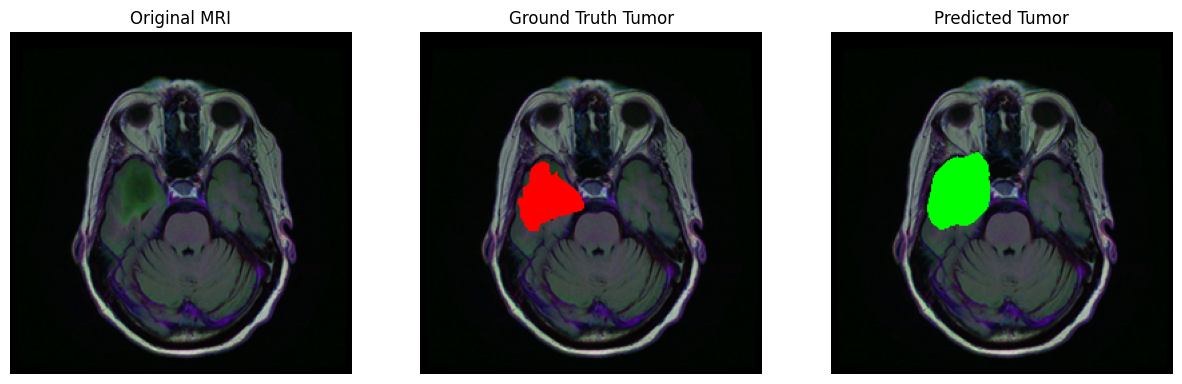

In [ ]:
def show_dl_prediction_overlay(index):
    img = X_test[index]
    true_mask = y_test[index].squeeze()
    pred_mask = y_pred_dl_bin[index].squeeze()

    # Scale image for correct display
    display_img = (img - img.min()) / (img.max() - img.min())

    # Overlay prediction on MRI
    overlay_pred = display_img.copy()
    overlay_pred[pred_mask == 1] = [0, 255, 0]  # green tumor

    # Overlay ground truth on MRI
    overlay_true = display_img.copy()
    overlay_true[true_mask == 1] = [255, 0, 0]  # red tumor

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(display_img)
    plt.title("Original MRI")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay_true)
    plt.title("Ground Truth Tumor")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_pred)
    plt.title("Predicted Tumor")
    plt.axis("off")

    plt.show()

#first sample prediction
show_dl_prediction_overlay(0)

In [ ]:
# Save model architecture
model_json = deeplab_model.to_json()
with open("DeepLabV3plus_model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
deeplab_model.save_weights("DeepLabV3plus.weights.h5")
print("DeepLabV3+ model saved successfully.")


DeepLabV3+ model saved successfully.


In [ ]:
from tensorflow.keras.models import model_from_json

# Load architecture
with open("DeepLabV3plus_model.json", "r") as json_file:
    model_json = json_file.read()

# load model with tversky for the metrics
custom_objects = {'focal_tversky': focal_tversky, 'tversky': tversky}
dlmodel = model_from_json(model_json, custom_objects=custom_objects)

# load weights
dlmodel.load_weights("DeepLabV3plus.weights.h5")

# Compile model
dlmodel.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_tversky,
    metrics=[tversky]
)



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 185 variables whereas the saved optimizer has 368 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


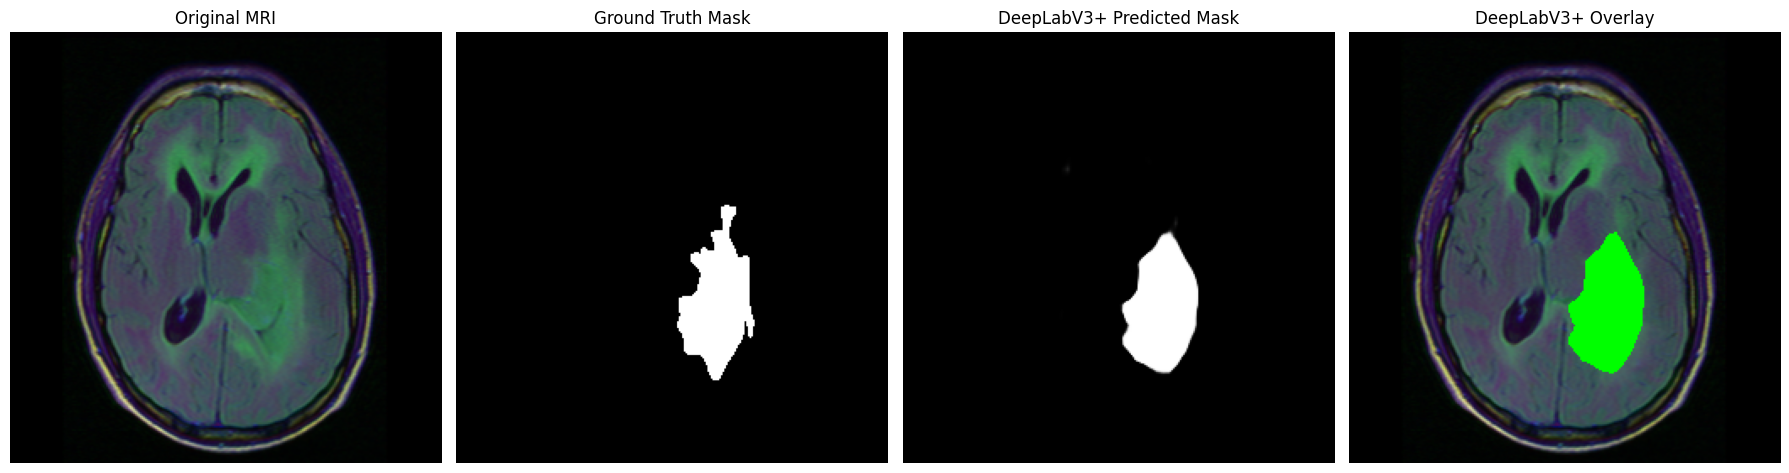

In [ ]:

mri_topredict = "/content/drive/MyDrive/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_12.tif"
maskgroundtruth = '/content/drive/MyDrive/archive/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_12_mask.tif'
show_segmentation(mri_topredict,maskgroundtruth, dlmodel, model_name='DeepLabV3+')
